In [1]:
#Для построения архитектуры ESN использовалась библиотека reservoirPy, основанная на графовых вычислениях
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy.datasets import to_forecasting # разбиение на train/test
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge #узлы резервуара и считывающего слоя
from reservoirpy.observables import nrmse, rsquare
import json
from scipy.integrate import solve_ivp
import copy
import warnings
from nolitsa import data

In [2]:

###ПОДГОТОВКА ДАННЫХ
#9
dt = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]


x = data.lorenz(length=4000, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
time = copy.deepcopy(x) #берем значения Лоренца
X = time[:,0] #берем только x
X = X.reshape(4000,1) #зачем-то 
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1 #нормализация(?)

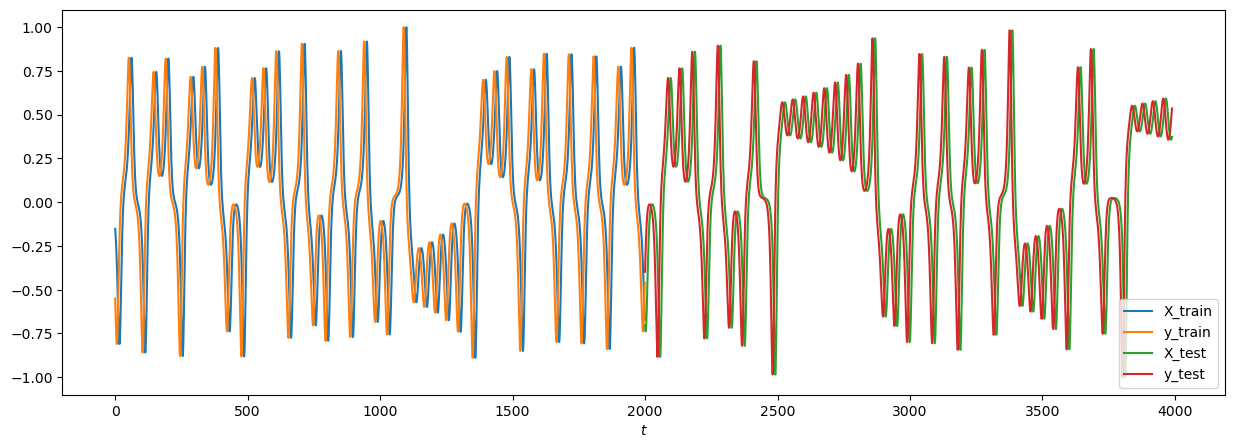

Running Model-0: 2000it [00:00, 4264.37it/s]<?, ?it/s]
Running Model-0: 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Fitting node Ridge-0...


Running Model-0: 1990it [00:00, 4741.28it/s]          


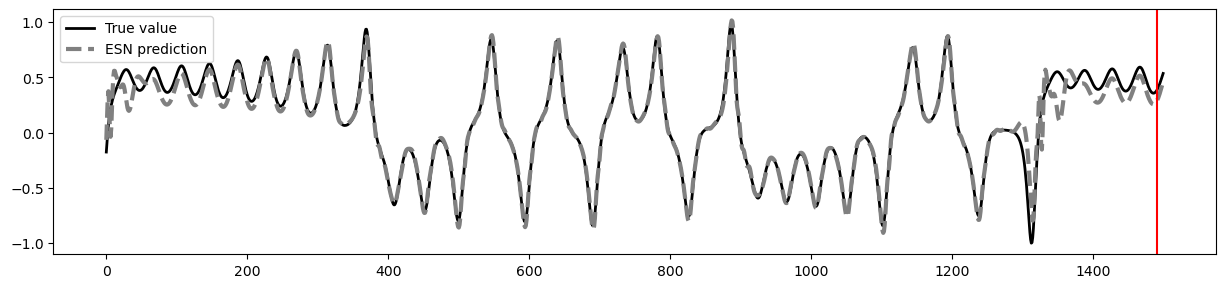

In [3]:
def train_test(X_train, y_train, X_test, y_test):
    sample = 2000
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 5))
    plt.plot(np.arange(0, 2000), X_train[-sample:], label="X_train")
    plt.plot(np.arange(0, 2000), y_train[-sample:], label="y_train")
    plt.plot(np.arange(2000, 2000+test_len), X_test, label="X_test")
    plt.plot(np.arange(2000, 2000+test_len), y_test, label="y_test")
    plt.xlabel(r'$t$')
    plt.legend()
    plt.show()
    
def results(y_pred, y_test, sample=1500):
    fig = plt.figure(figsize=(15, 7))
    ax = plt.subplot(211)
    ax.plot(np.arange(sample), y_test[len(y_test)-sample:], lw=2, label="True value", color="black")
    ax.plot(np.arange(sample), y_pred[len(y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")
    ax.axvline(x=sample-10, color="red")  # Add vertical line
    ax.legend()
    plt.show()
    
###HERE0
x, y = to_forecasting(X, forecast=10)

X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]

train_test(X_train1, y_train1, X_test1, y_test1)

#Первый тестовый набор параметров 
units = 100
leak_rate = 0.3
spectral_radius = 1.25
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.2
regularization = 1e-8
seed = 1234

#узел резервуара
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)
#выходной слой(считывающее устройство)
readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
#соединяем узлы и таким образом получаем модель 
esn = reservoir >> readout

#обучение модели
esn = esn.fit(X_train1, y_train1)
#делаем предсказание
y_pred1 = esn.run(X_test1)
results(y_pred1, y_test1, sample=1500)
###HERE1

Будет класс предсказатель 1, он принимает X_train1, y_train1, X_test1, y_test1(только для сравнения), число шагов предсказания, ну и свои гиперапраметры всякие, он должен отрисовать графики, вернуть предсказанный массив и показатель ляпунова.

In [5]:
class reservoir_predictor1:
    def __init__(self, 
                X, 
                prediction_steps = 10,
                exchange = 2000,
                units = 100,
                leak_rate = 0.3,
                spectral_radius = 1.25,
                input_scaling = 1.0,
                connectivity = 0.1,
                input_connectivity = 0.2,
                regularization = 1e-8,
                seed = 1234):
        self.X = X
        self.x, self.y = to_forecasting(X, forecast=prediction_steps)
        self.X_train1, self.y_train1 = x[:exchange], y[:exchange]
        self.X_test1, self.y_test1 = x[exchange:], y[exchange:]
        self.prediction_steps = prediction_steps
        self.exchange = exchange

        self.units = units
        self.leak_rate = leak_rate
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.connectivity = connectivity
        self.input_connectivity = input_connectivity
        self.regularization = regularization
        self.seed = seed
    
    def train_test(self):
        sample = 2000
        test_len = self.X_test.shape[0]
        fig = plt.figure(figsize=(15, 5))
        plt.plot(np.arange(0, 2000), self.X_train[-sample:], label="X_train")
        plt.plot(np.arange(0, 2000), self.y_train[-sample:], label="y_train")
        plt.plot(np.arange(2000, 2000+test_len), self.X_test, label="X_test")
        plt.plot(np.arange(2000, 2000+test_len), self.y_test, label="y_test")
        plt.xlabel(r'$t$')
        plt.legend()
        plt.show()
        
    def results(self, sample=1500):
        fig = plt.figure(figsize=(15, 7))
        ax = plt.subplot(211)
        ax.plot(np.arange(sample), self.y_test[len(self.y_test)-sample:], lw=2, label="True value", color="black")
        ax.plot(np.arange(sample), self.y_pred[len(self.y_pred)-sample:], lw=3, label="ESN prediction", color="gray", linestyle="--")
        ax.axvline(x=sample-self.prediction_steps, color="red")  # Add vertical line
        ax.legend()
        plt.show()

    def do(self):
        ###HERE
        train_test(X_train1, y_train1, X_test1, y_test1)

        #узел резервуара
        reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                            lr=leak_rate, rc_connectivity=connectivity,
                            input_connectivity=input_connectivity, seed=seed)
        #выходной слой(считывающее устройство)
        readout = Ridge(1, ridge=regularization) # 1 - кол-во выходных нейронов
        #соединяем узлы и таким образом получаем модель 
        esn = reservoir >> readout

        #обучение модели
        esn = esn.fit(X_train1, y_train1)
        #делаем предсказание
        y_pred1 = esn.run(X_test1)
        results(y_pred1, y_test1, sample=1500)
        ###HERE1
        return y_pred1

In [4]:
q = [1, 2, 3, 4]
q[2:]

[3, 4]

In [6]:

###ПОДГОТОВКА ДАННЫХ
#9
dt = 0.01
x0 = [0.62225717, -0.08232857, 30.60845379]


x = data.lorenz(length=4000, sample=dt, x0=x0,
               sigma=16.0, beta=4.0, rho=45.92)[1]

#11
time = copy.deepcopy(x) #берем значения Лоренца
X = time[:,0] #берем только x
X = X.reshape(4000,1) #зачем-то 
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1 #нормализация(?)

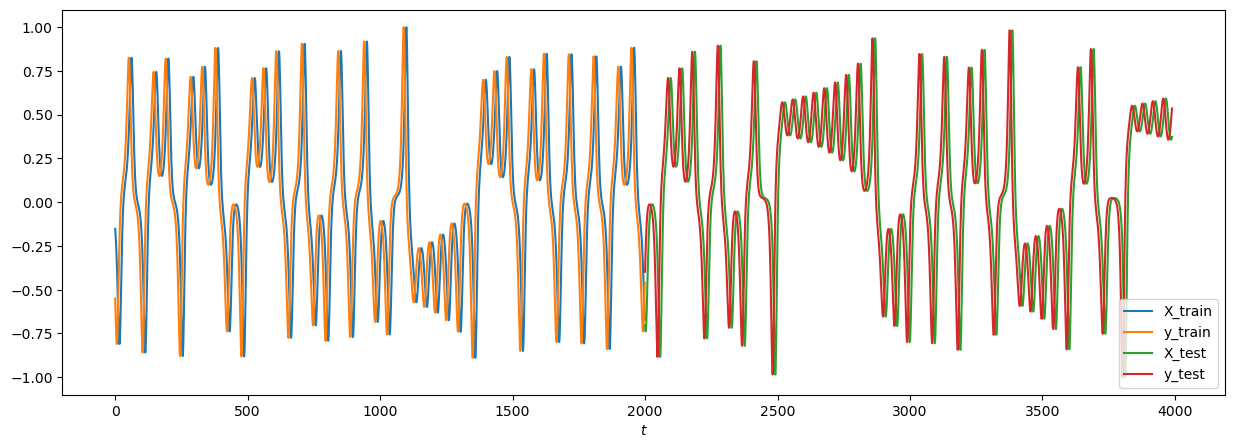

Running Model-1: 2000it [00:00, 7380.11it/s]<?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Fitting node Ridge-1...


Running Model-1: 1990it [00:00, 8431.62it/s]          


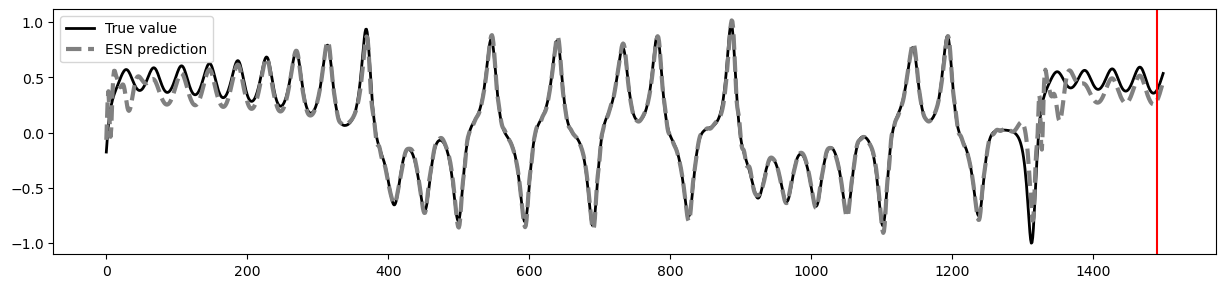

In [7]:

model = reservoir_predictor1(X=X)
pred = model.do()

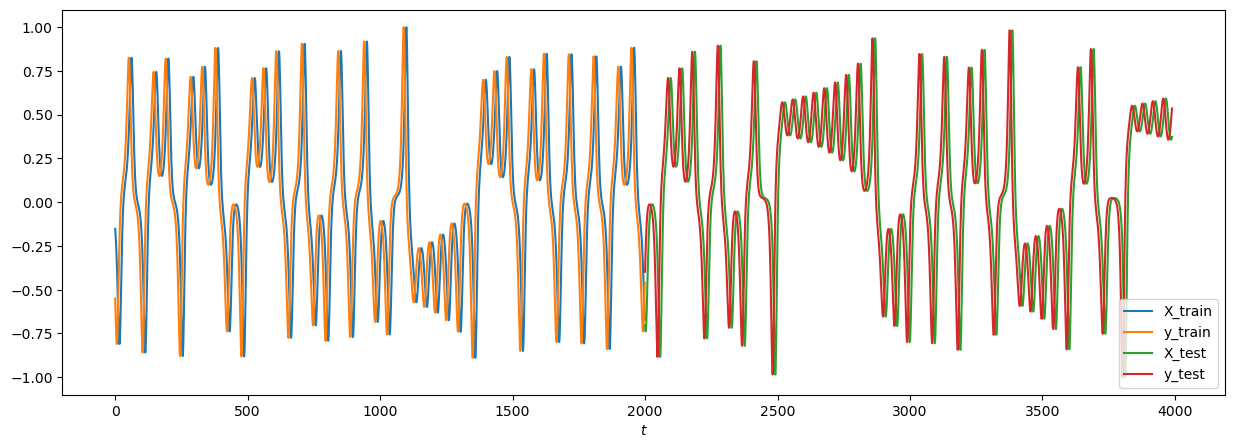

Running Model-3: 2000it [00:00, 8163.33it/s]<?, ?it/s]
Running Model-3: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Fitting node Ridge-3...


Running Model-3: 1990it [00:00, 7865.92it/s]          


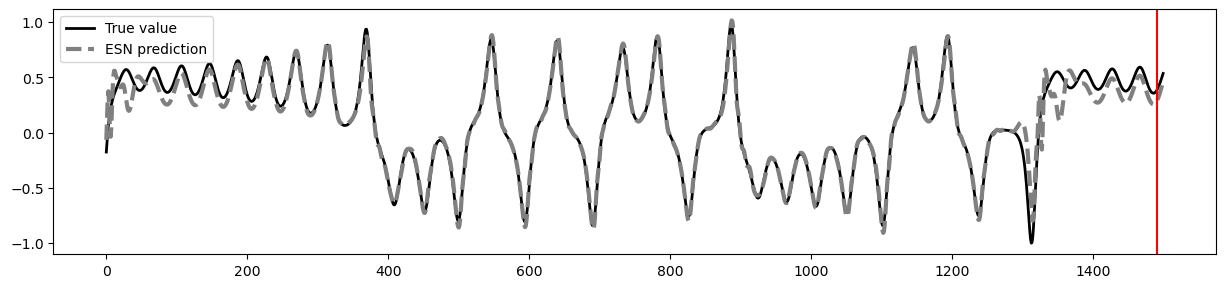

In [9]:
model = reservoir_predictor1(X=X, prediction_steps = 100)
pred = model.do()